# Feature Overview

This notebook provides a simple overview of the basic functionality of PySINDy. In addition to demonstrating the basic usage for fitting a SINDy model, we demonstrate several means of customizing the SINDy fitting procedure. These include different forms of input data, different optimization methods, different differentiation methods, and custom feature libraries.

An interactive version of this notebook is available on binder.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v1.7?filepath=examples/1_feature_overview.ipynb)

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso

from pysindy.utils import enzyme
from pysindy.utils import lorenz
from pysindy.utils import lorenz_control
import pysindy as ps

# bad code but allows us to ignore warnings
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Seed the random number generators for reproducibility
np.random.seed(100)

### A note on solve_ivp vs odeint before we continue
The default solver for `solve_ivp` is a Runga-Kutta method (RK45) but this seems to work quite poorly on a number of these examples, likely because they are multi-scale and chaotic. Instead, the LSODA method seems to perform quite well (ironically this is the default for the older `odeint` method). This is a nice reminder that system identification is important to get the right model, but a good integrator is still needed at the end!

In [3]:
# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

## Basic usage
We will fit a SINDy model to the famous Lorenz system:
$$ \dot{x} = \sigma (y - x),$$
$$ \dot{y} = x(\rho - z) - y, $$
$$ \dot{z} = x y - \beta z. $$


### Train the model

In [4]:
# Generate measurement data
dt = .002

t_train = np.arange(0, 10, dt)
x0_train = [-8, 8, 27]
t_train_span = (t_train[0], t_train[-1])
x_train = solve_ivp(lorenz, t_train_span, x0_train, 
                    t_eval=t_train, **integrator_keywords).y.T

In [5]:
# Instantiate and fit the SINDy model
model = ps.SINDy()
model.fit(x_train, t=dt)
model.print()

(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1


### Assess results on a test trajectory

In [6]:
# Evolve the Lorenz equations in time using a different initial condition
t_test = np.arange(0, 15, dt)
x0_test = np.array([8, 7, 15])
t_test_span = (t_test[0], t_test[-1])
x_test = solve_ivp(lorenz, t_test_span, x0_test, 
                   t_eval=t_test, **integrator_keywords).y.T  

# Compare SINDy-predicted derivatives with finite difference derivatives
print('Model score: %f' % model.score(x_test, t=dt))

Model score: 1.000000


### Predict derivatives with learned model

/tmp/ipykernel_23392/1190763031.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


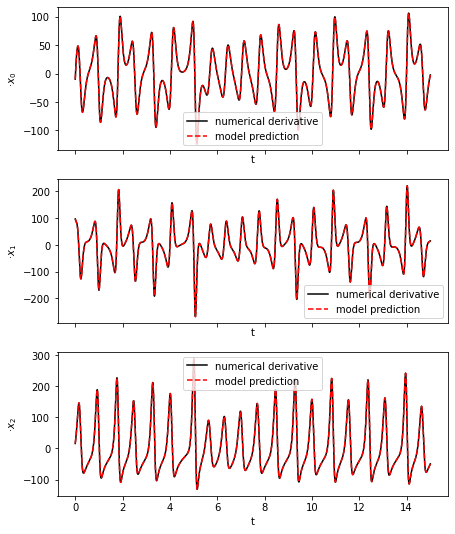

In [7]:
# Predict derivatives using the learned model
x_dot_test_predicted = model.predict(x_test)  

# Compute derivatives with a finite difference method, for comparison
x_dot_test_computed = model.differentiate(x_test, t=dt)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_dot_test_computed[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t_test, x_dot_test_predicted[:, i],
                'r--', label='model prediction')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
fig.show()

### Simulate forward in time

/tmp/ipykernel_23392/1409438043.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


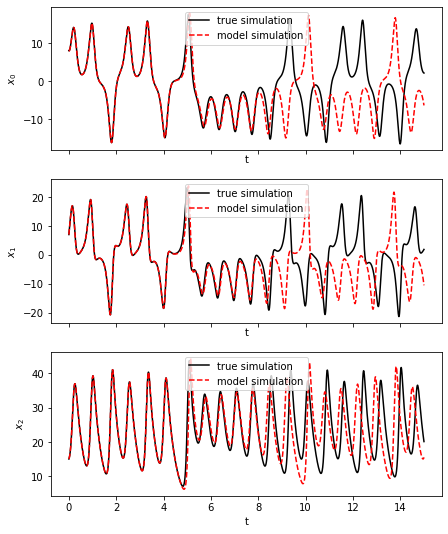

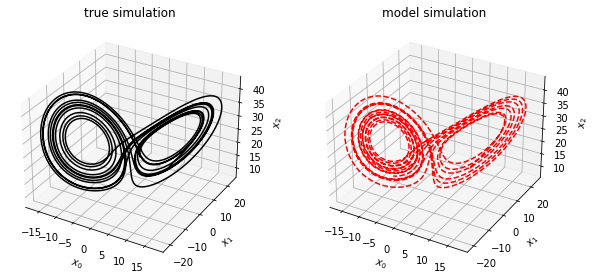

In [8]:
# Evolve the new initial condition in time with the SINDy model
x_test_sim = model.simulate(x0_test, t_test)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_test[:, i], 'k', label='true simulation')
    axs[i].plot(t_test, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))

fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], 'k')
ax1.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='true simulation')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_test_sim[:, 0], x_test_sim[:, 1], x_test_sim[:, 2], 'r--')
ax2.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='model simulation')

fig.show()

## Different forms of input data

Here we explore different types of input data accepted by the the `SINDy` class.

### Single trajectory, pass in collection times

In [9]:
model = ps.SINDy()
model.fit(x_train, t=t_train)
model.print()

(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1


### Single trajectory, set default timestep
Since we used a uniform timestep when defining `t_train` we can tell set a default timestep to be used whenever `t` isn't passed in.

In [10]:
model = ps.SINDy(t_default=dt)
model.fit(x_train)
model.print()

(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1


### Single trajectory, pass in pre-computed derivatives

In [11]:
x_dot_true = np.zeros(x_train.shape)
for i in range(t_train.size):
    x_dot_true[i] = lorenz(t_train[i], x_train[i])
    
model = ps.SINDy()
model.fit(x_train, t=t_train, x_dot=x_dot_true)
model.print()

(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 28.000 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1


### Multiple trajectories
We use the Lorenz equations to evolve multiple different initial conditions forward in time, passing all the trajectories into a single `SINDy` object. Note that `x_train_multi` is a list of 2D numpy arrays.

In [12]:
n_trajectories = 20
x0s = np.array([36, 48, 41]) * (
    np.random.rand(n_trajectories, 3) - 0.5
) + np.array([0, 0, 25])
x_train_multi = []
for i in range(n_trajectories):
    x_train_multi.append(solve_ivp(lorenz, t_train_span, x0s[i], 
                                   t_eval=t_train, **integrator_keywords).y.T)

model = ps.SINDy()
model.fit(x_train_multi, t=dt, multiple_trajectories=True)
model.print()

(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.993 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1


### Multiple trajectories, different lengths of time
This example is similar to the previous one, but each trajectory consists of a different number of measurements.

In [13]:
n_trajectories = 20
x0s = np.array([36, 48, 41]) * (
    np.random.rand(n_trajectories, 3) - 0.5
) + np.array([0, 0, 25])
x_train_multi = []
t_train_multi = []
for i in range(n_trajectories):
    n_samples = np.random.randint(500, 1500)
    t = np.arange(0, n_samples * dt, dt)
    t_span = (t[0], t[-1])
    x_train_multi.append(solve_ivp(lorenz, t_span, x0s[i], 
                                   t_eval=t, **integrator_keywords).y.T)
    t_train_multi.append(t)

model = ps.SINDy()
model.fit(x_train_multi, t=t_train_multi, multiple_trajectories=True)
model.print()

(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.994 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1


### Discrete time dynamical system (map)

In [14]:
def f(x):
    return 3.6 * x * (1 - x)


n_steps = 1000
eps = 0.001  # Noise level
x_train_map = np.zeros((n_steps))
x_train_map[0] = 0.5
for i in range(1, n_steps):
    x_train_map[i] = f(x_train_map[i - 1]) + eps * np.random.randn()
model = ps.SINDy(discrete_time=True)
model.fit(x_train_map)

model.print()

(x0)[k+1] = 3.600 x0[k] + -3.600 x0[k]^2


### Pandas DataFrame

In [15]:
import pandas as pd

# Create a dataframe with entries corresponding to measurements and
# indexed by the time at which the measurements were taken
df = pd.DataFrame(data=x_train, columns=['x', 'y', 'z'], index=t_train)

# The column names can be used as feature names
model = ps.SINDy(feature_names=df.columns)

# Everything needs to be converted to numpy arrays to be passed in
model.fit(df.values, t=df.index.values)
model.print()

(x)' = -9.999 x + 9.999 y
(y)' = 27.992 x + -0.999 y + -1.000 x z
(z)' = -2.666 z + 1.000 x y


## Optimization options
In this section we provide examples of different parameters accepted by the built-in sparse regression optimizers `STLSQ`, `SR3`, `ConstrainedSR3`, `SSR`, and `FROLS`. The `Trapping` optimizer is not straightforward to use; please check out Example 8 for some examples. We also show how to use a scikit-learn sparse regressor with PySINDy.

### STLSQ - change parameters

In [16]:
stlsq_optimizer = ps.STLSQ(threshold=.01, alpha=.5)

model = ps.SINDy(optimizer=stlsq_optimizer)
model.fit(x_train, t=dt)
model.print()

(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1


### STLSQ - verbose (print out optimization terms at each iteration)
The same verbose option is available with all the other optimizers. For optimizers that use the CVXPY
package, there is additional boolean flag, verbose_cvxpy, that decides whether or not CVXPY solves will also be verbose.

In [17]:
stlsq_optimizer = ps.STLSQ(threshold=.01, alpha=.5, verbose=True)

model = ps.SINDy(optimizer=stlsq_optimizer)
model.fit(x_train, t=dt)
model.print()

 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 3.1040e+01 ... 4.9652e+02 ...          8 ... 5.2756e+02
         1 ... 1.1797e+00 ... 4.9674e+02 ...          7 ... 4.9792e+02
         2 ... 1.1712e+00 ... 4.9675e+02 ...          7 ... 4.9792e+02
(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1


### SR3

In [18]:
sr3_optimizer = ps.SR3(threshold=0.1, thresholder='l1')

model = ps.SINDy(optimizer=sr3_optimizer)
model.fit(x_train, t=dt)
model.print()

(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1


### SR3 - with trimming
`SR3` is capable of automatically trimming outliers from training data. Specifying the parameter `trimming_fraction` tells the method what fraction of samples should be trimmed.

In [19]:
corrupted_inds = np.random.randint(0, len(x_train), size=len(x_train) // 30)
x_train_corrupted = x_train.copy()
x_train_corrupted[corrupted_inds] += np.random.standard_normal((len(corrupted_inds), 3))

# Without trimming
sr3_optimizer = ps.SR3()
model = ps.SINDy(optimizer=sr3_optimizer).fit(x_train_corrupted, t=dt, quiet=True)
print("Without trimming")
model.print()

# With trimming
sr3_optimizer = ps.SR3(trimming_fraction=0.1)
model = ps.SINDy(optimizer=sr3_optimizer).fit(x_train_corrupted, t=dt, quiet=True)
print("\nWith trimming")
model.print()

Without trimming
(x0)' = -0.063 1 + -9.936 x0 + 9.941 x1 + 0.002 x2
(x1)' = 0.144 1 + 27.993 x0 + -0.995 x1 + -0.014 x2 + 0.004 x0^2 + -1.000 x0 x2
(x2)' = -0.053 1 + 0.007 x1 + -2.661 x2 + 0.998 x0 x1

With trimming
(x0)' = -9.936 x0 + 9.941 x1
(x1)' = 27.997 x0 + -0.995 x1 + -1.000 x0 x2
(x2)' = -2.662 x2 + 0.998 x0 x1


### SR3 regularizers 
The default regularizer with SR3 is the L0 norm, but L1 and L2 are allowed. Note that the pure L2 option is notably less sparse than the other options.

In [20]:
sr3_optimizer = ps.SR3(threshold=0.1, thresholder='l0')
model = ps.SINDy(optimizer=sr3_optimizer).fit(x_train, t=dt, quiet=True)
print("L0 regularizer: ")
model.print()

sr3_optimizer = ps.SR3(threshold=0.1, thresholder="l1")
model = ps.SINDy(optimizer=sr3_optimizer).fit(x_train, t=dt, quiet=True)
print("L1 regularizer: ")
model.print()

sr3_optimizer = ps.SR3(threshold=0.1, thresholder="l2")
model = ps.SINDy(optimizer=sr3_optimizer).fit(x_train, t=dt, quiet=True)
print("L2 regularizer: ")
model.print()

L0 regularizer: 
(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1
L1 regularizer: 
(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1
L2 regularizer: 
(x0)' = -0.001 1 + -10.005 x0 + 10.003 x1
(x1)' = -0.015 1 + 27.991 x0 + -0.998 x1 + 0.002 x2 + -1.000 x0 x2
(x2)' = 0.008 1 + 0.006 x0 + -0.004 x1 + -2.666 x2 + 0.001 x0^2 + 0.999 x0 x1


### SR3 - with variable thresholding
`SR3` and its variants (ConstrainedSR3, TrappingSR3, SINDyPI) can use a matrix of thresholds to set different thresholds for different terms.

In [21]:
# Without thresholds matrix
sr3_optimizer = ps.SR3(threshold=0.1, thresholder='l0')
model = ps.SINDy(optimizer=sr3_optimizer).fit(x_train, t=dt)
print("Threshold = 0.1 for all terms")
model.print()

# With thresholds matrix
thresholds = 2 * np.ones((10, 3))
thresholds[4:, :] = 0.1
sr3_optimizer = ps.SR3(thresholder="weighted_l0", thresholds=thresholds)
model = ps.SINDy(optimizer=sr3_optimizer).fit(x_train, t=dt)
print("Threshold = 0.1 for quadratic terms, else threshold = 1")
model.print()

Threshold = 0.1 for all terms
(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1
Threshold = 0.1 for quadratic terms, else threshold = 1
(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 25.563 x0 + -0.952 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1


It can be seen that the x1 term in the second equation correctly gets truncated with these thresholds. 

### ConstrainedSR3
We can impose linear equality and inequality constraints on the coefficients in the `SINDy` model using the `ConstrainedSR3` class. Below we constrain the x0 coefficient in the second equation to be exactly 28 and the x0 and x1 coefficients in the first equations to be negatives of one another. See this [notebook](https://github.com/dynamicslab/pysindy/blob/master/examples/7_plasma_examples.ipynb) for examples.

In [22]:
# Figure out how many library features there will be
library = ps.PolynomialLibrary()
library.fit([ps.AxesArray(x_train,{"ax_sample":0,"ax_coord":1})])
n_features = library.n_output_features_
print(f"Features ({n_features}):", library.get_feature_names())

Features (10): ['1', 'x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2']


In [23]:
# Set constraints
n_targets = x_train.shape[1]
constraint_rhs = np.array([0, 28])

# One row per constraint, one column per coefficient
constraint_lhs = np.zeros((2, n_targets * n_features))

# 1 * (x0 coefficient) + 1 * (x1 coefficient) = 0
constraint_lhs[0, 1] = 1
constraint_lhs[0, 2] = 1

# 1 * (x0 coefficient) = 28
constraint_lhs[1, 1 + n_features] = 1

optimizer = ps.ConstrainedSR3(constraint_rhs=constraint_rhs, constraint_lhs=constraint_lhs)
model = ps.SINDy(optimizer=optimizer, feature_library=library).fit(x_train, t=dt)
model.print()

(x0)' = -10.002 x0 + 10.002 x1
(x1)' = 28.000 x0 + -1.003 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 0.999 x0 x1


In [24]:
# Try with normalize columns (doesn't work with constraints!!!)
optimizer = ps.ConstrainedSR3(constraint_rhs=constraint_rhs, 
                              constraint_lhs=constraint_lhs,
                              normalize_columns=True, 
                              threshold=10)
model = ps.SINDy(optimizer=optimizer, 
                 feature_library=library).fit(x_train, t=dt, quiet=True)
model.print()

(x0)' = -11.085 x0 + 9.701 x1 + 0.020 x2 + 0.021 x0 x2 + 0.025 x1 x2
(x1)' = 2.338 1 + 0.050 x0 + 10.311 x1 + 0.368 x2 + -0.047 x0^2 + 0.197 x0 x1 + -0.308 x0 x2 + -0.125 x1^2 + -0.183 x1 x2 + -0.006 x2^2
(x2)' = -2.666 x2 + 1.000 x0 x1


In [25]:
# Repeat with inequality constraints
eps = 1e-5
constraint_rhs = np.array([eps, eps, 28])

# One row per constraint, one column per coefficient
constraint_lhs = np.zeros((3, n_targets * n_features))

# 1 * (x0 coefficient) + 1 * (x1 coefficient) <= eps
constraint_lhs[0, 1] = 1
constraint_lhs[0, 2] = 1

# -eps <= 1 * (x0 coefficient) + 1 * (x1 coefficient)
constraint_lhs[1, 1] = -1
constraint_lhs[1, 2] = -1

# 1 * (x0 coefficient) <= 28
constraint_lhs[2, 1 + n_features] = 1

optimizer = ps.ConstrainedSR3(
    constraint_rhs=constraint_rhs,
    constraint_lhs=constraint_lhs,
    inequality_constraints=True,
    thresholder="l1",
    tol=1e-7,
    threshold=10,
    max_iter=10000
)
model = ps.SINDy(optimizer=optimizer, 
                 feature_library=library).fit(x_train, t=dt)
model.print()
print(optimizer.coef_[0, 1], optimizer.coef_[0, 2])

(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 27.985 x0 + -0.994 x1 + -1.000 x0 x2
(x2)' = 0.001 x0 + -2.665 x2 + 0.001 x0^2 + 0.999 x0 x1
-10.00012555030451 10.00013553730483


/home/zack/anaconda3/envs/pysindy_env/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


### SSR (greedy algorithm)
Stepwise sparse regression (SSR) is a greedy algorithm which solves the problem (defaults to ridge regression) by iteratively truncating the smallest coefficient during the optimization. There are many ways one can decide to truncate terms. We implement two popular ways, truncating the smallest coefficient at each iteration, or chopping each coefficient, computing N - 1 models, and then choosing the model with the lowest residual error. See this [notebook](https://github.com/dynamicslab/pysindy/blob/master/examples/11_SSR_FROLS.ipynb) for examples.

In [26]:
ssr_optimizer = ps.SSR(alpha=.05)

model = ps.SINDy(optimizer=ssr_optimizer)
model.fit(x_train, t=dt)
model.print()

(x0)' = -0.001 1 + -10.005 x0 + 10.003 x1
(x1)' = -0.015 1 + 27.991 x0 + -0.998 x1 + 0.002 x2 + -1.000 x0 x2
(x2)' = 0.008 1 + 0.006 x0 + -0.004 x1 + -2.666 x2 + 0.001 x0^2 + 0.999 x0 x1


The alpha parameter is the same here as in the STLSQ optimizer. It determines the amount of L2 regularization to use, so if alpha is nonzero, this is doing Ridge regression rather than least-squares regression.

In [27]:
ssr_optimizer = ps.SSR(alpha=.05, criteria="model_residual")
model = ps.SINDy(optimizer=ssr_optimizer)
model.fit(x_train, t=dt)
model.print()

(x0)' = -0.001 1 + -10.005 x0 + 10.003 x1
(x1)' = -0.015 1 + 27.991 x0 + -0.998 x1 + 0.002 x2 + -1.000 x0 x2
(x2)' = 0.008 1 + 0.006 x0 + -0.004 x1 + -2.666 x2 + 0.001 x0^2 + 0.999 x0 x1


The kappa parameter determines how sparse a solution is desired.

In [28]:
ssr_optimizer = ps.SSR(alpha=.05, criteria="model_residual", kappa=1e-3)
model = ps.SINDy(optimizer=ssr_optimizer)
model.fit(x_train, t=dt)
model.print()

(x0)' = -10.004 x0 + 10.003 x1
(x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -2.665 x2 + 1.000 x0 x1


### FROLS (greedy algorithm)
Forward Regression Orthogonal Least Squares (FROLS) is another greedy algorithm which solves the least-squares regression problem (actually default is to solve ridge regression) with $L_0$ norm by iteratively selecting the most correlated function in the library. At each step, the candidate functions are orthogonalized with respect to the already-selected functions. The selection criteria is the Error Reduction Ratio, i.e. the normalized increase in the explained output variance due to the addition of a given function to the basis. See this [notebook](https://github.com/dynamicslab/pysindy/blob/master/examples/11_SSR_FROLS.ipynb) for examples.

In [29]:
optimizer = ps.FROLS(alpha=.05)
model = ps.SINDy(optimizer=optimizer)
model.fit(x_train, t=dt)
model.print()

(x0)' = -0.001 1 + -10.005 x0 + 10.003 x1
(x1)' = -0.005 1 + 27.990 x0 + -0.997 x1 + -1.000 x0 x2
(x2)' = 0.019 1 + -2.668 x2 + 0.999 x0 x1


The kappa parameter determines how sparse a solution is desired.

In [30]:
optimizer = ps.FROLS(alpha=.05, kappa=1e-7)
model = ps.SINDy(optimizer=optimizer)
model.fit(x_train, t=dt)
model.print()

(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -0.001 1 + -2.666 x2 + 1.000 x0 x1


### LASSO
In this example we use a third-party Lasso implementation (from scikit-learn) as the optimizer.

In [31]:
lasso_optimizer = Lasso(alpha=2, max_iter=2000, fit_intercept=False)

model = ps.SINDy(optimizer=lasso_optimizer)
model.fit(x_train, t=dt)
model.print()

(x0)' = -10.005 x0 + 10.003 x1
(x1)' = 27.990 x0 + -0.997 x1 + -1.000 x0 x2
(x2)' = -2.665 x2 + 1.000 x0 x1


### Ensemble methods
One way to improve SINDy performance is to generate many models by sub-sampling the time series (ensemble) or sub-sampling the candidate library $\mathbf{\Theta}$ (library ensemble). The resulting models can then be synthesized by taking the average (bagging), taking the median (this is the recommended because it works well in practice), or some other post-processing. See this [notebook](https://github.com/dynamicslab/pysindy/blob/master/examples/13_ensembling.ipynb) for more examples.

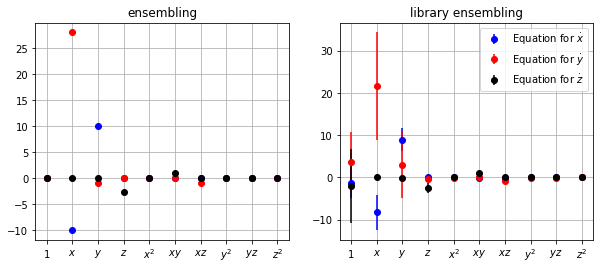

In [32]:
# Default is to sample the entire time series with replacement, generating 10 models on roughly 
# 60% of the total data, with duplicates. 

# Custom feature names
np.random.seed(100)
feature_names = ['x', 'y', 'z']

ensemble_optimizer = ps.EnsembleOptimizer(ps.STLSQ(threshold=1e-3,normalize_columns=False),bagging=True,n_subset=int(0.6*x_train.shape[0]))

model = ps.SINDy(optimizer=ensemble_optimizer, feature_names=feature_names)
model.fit(x_train, t=dt)
ensemble_coefs = ensemble_optimizer.coef_list
mean_ensemble = np.mean(ensemble_coefs, axis=0)
std_ensemble = np.std(ensemble_coefs, axis=0)

# Now we sub-sample the library. The default is to omit a single library term.
library_ensemble_optimizer=ps.EnsembleOptimizer(ps.STLSQ(threshold=1e-3,normalize_columns=False),library_ensemble=True)
model = ps.SINDy(optimizer=library_ensemble_optimizer, feature_names=feature_names)

model.fit(x_train, t=dt)
library_ensemble_coefs = library_ensemble_optimizer.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

# Plot results
xticknames = model.get_feature_names()
for i in range(10):
    xticknames[i] = '$' + xticknames[i] + '$'
plt.figure(figsize=(10, 4))
colors = ['b', 'r', 'k']
plt.subplot(1, 2, 1)
plt.title('ensembling')
for i in range(3):
    plt.errorbar(range(10), mean_ensemble[i, :], yerr=std_ensemble[i, :], 
                 fmt='o', color=colors[i],
                 label=r'Equation for $\dot{' + feature_names[i] + r'}$')
ax = plt.gca()
plt.grid(True)
ax.set_xticks(range(10))
ax.set_xticklabels(xticknames, verticalalignment='top')
plt.subplot(1, 2, 2)
plt.title('library ensembling')
for i in range(3):
    plt.errorbar(range(10), mean_library_ensemble[i, :], yerr=std_library_ensemble[i, :], 
                 fmt='o', color=colors[i], 
                 label=r'Equation for $\dot{' + feature_names[i] + r'}$')
ax = plt.gca()
plt.grid(True)
plt.legend()
ax.set_xticks(range(10))
ax.set_xticklabels(xticknames, verticalalignment='top');

## Differentiation options

### Pass in pre-computed derivatives
Rather than using one of PySINDy's built-in differentiators, you can compute numerical derivatives using a method of your choice then pass them directly to the `fit` method. This option also enables you to use derivative data obtained directly from experiments.

In [33]:
x_dot_precomputed = ps.FiniteDifference()._differentiate(x_train, t_train)
    
model = ps.SINDy()
model.fit(x_train, t=t_train, x_dot=x_dot_precomputed)
model.print()

(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1


### Drop end points from finite difference computation
Many methods of numerical differentiation exhibit poor performance near the endpoints of the data. The `FiniteDifference` and `SmoothedFiniteDifference` methods allow one to easily drop the endpoints for improved accuracy.

In [34]:
fd_drop_endpoints = ps.FiniteDifference(drop_endpoints=True)
    
model = ps.SINDy(differentiation_method=fd_drop_endpoints)
model.fit(x_train, t=t_train)
model.print()

(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.998 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1


### Differentiation along specific array axis
For partial differential equations (PDEs), you may have spatiotemporal data in a multi-dimensional array. For this case, the `FiniteDifference` method allows one to only differential along a specific axis, so one can easily differentiate in a specific spatial direction.

/tmp/ipykernel_23392/677670981.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, X, x)
/tmp/ipykernel_23392/677670981.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, X, x_dot)


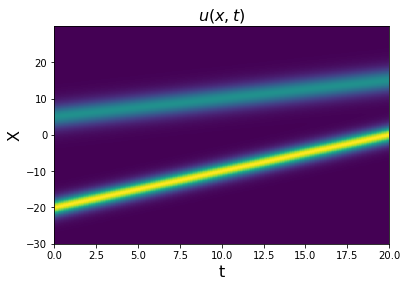

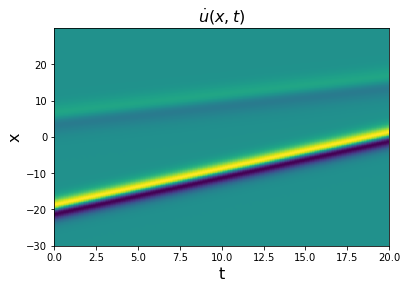

In [35]:
from scipy.io import loadmat

# Load the data stored in a matlab .mat file
kdV = loadmat('data/kdv.mat')
t = np.ravel(kdV['t'])
X = np.ravel(kdV['x'])
x = np.real(kdV['usol'])
dt_kdv = t[1] - t[0]

# Plot x and x_dot
plt.figure()
plt.pcolormesh(t, X, x)
plt.xlabel('t', fontsize=16)
plt.ylabel('X', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
plt.figure()
x_dot = ps.FiniteDifference(axis=1)._differentiate(x, t=dt_kdv)

plt.pcolormesh(t, X, x_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

### Smoothed finite difference
This method, designed for noisy data, applies a smoother (the default is `scipy.signal.savgol_filter`) before performing differentiation.

In [36]:
smoothed_fd = ps.SmoothedFiniteDifference()
    
model = ps.SINDy(differentiation_method=smoothed_fd)
model.fit(x_train, t=t_train)
model.print()

(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.998 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1


### More differentiation options
PySINDy is compatible with any of the differentiation methods from the [derivative](https://pypi.org/project/derivative/) package. They are explored in detail in [this notebook](https://github.com/dynamicslab/pysindy/blob/master/examples/5_differentiation.ipynb).

PySINDy defines a `SINDyDerivative` class for interfacing with `derivative` methods. To use a differentiation method provided by `derivative`, simply pass into `SINDyDerivative` the keyword arguments you would give the [dxdt](https://derivative.readthedocs.io/en/latest/api.html#derivative.differentiation.dxdt) method.

In [37]:
spline_derivative = ps.SINDyDerivative(kind="spline", s=1e-2)

model = ps.SINDy(differentiation_method=spline_derivative)
model.fit(x_train, t=t_train)
model.print()

(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 28.003 x0 + -1.001 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1


## Feature libraries

### Custom feature names

In [38]:
feature_names = ['x', 'y', 'z']
model = ps.SINDy(feature_names=feature_names)
model.fit(x_train, t=dt)
model.print()

(x)' = -9.999 x + 9.999 y
(y)' = 27.992 x + -0.999 y + -1.000 x z
(z)' = -2.666 z + 1.000 x y


### Custom left-hand side when printing the model

In [39]:
model = ps.SINDy()
model.fit(x_train, t=dt)
model.print(lhs=['dx0/dt', 'dx1/dt', 'dx2/dt'])

dx0/dt = -9.999 x0 + 9.999 x1
dx1/dt = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
dx2/dt = -2.666 x2 + 1.000 x0 x1


### Customize polynomial library
Omit interaction terms between variables, such as $x_0 x_1$.

In [40]:
poly_library = ps.PolynomialLibrary(include_interaction=False)

model = ps.SINDy(feature_library=poly_library,            
                 optimizer=ps.STLSQ(threshold=0.5))
model.fit(x_train, t=dt)
model.print()

(x0)' = -9.999 x0 + 9.999 x1
(x1)' = -12.142 x0 + 9.349 x1
(x2)' = 85.861 1 + 0.567 x0 + -7.354 x2 + 1.366 x0^2


### Fourier library

In [41]:
fourier_library = ps.FourierLibrary(n_frequencies=3)

model = ps.SINDy(feature_library=fourier_library, 
                 optimizer=ps.STLSQ(threshold=4))
model.fit(x_train, t=dt)
model.print()

(x0)' = 6.201 cos(1 x1)
(x1)' = -4.233 cos(1 x0) + -4.817 sin(1 x2) + 7.787 cos(1 x2) + -5.604 cos(2 x0) + 4.630 cos(3 x0) + 4.569 sin(3 x2)
(x2)' = 4.982 sin(1 x0) + 4.768 sin(1 x1) + -13.709 cos(2 x1) + 4.674 sin(3 x1) + -8.713 cos(3 x1)


### Fully custom library
The `CustomLibrary` class gives you the option to pass in function names to improve the readability of the printed model. Each function "name" should itself be a function.

In [42]:
library_functions = [
    lambda x : np.exp(x),
    lambda x : 1. / x,
    lambda x : x,
    lambda x,y : np.sin(x + y)
]
library_function_names = [
    lambda x : 'exp(' + x + ')',
    lambda x : '1/' + x,
    lambda x : x,
    lambda x,y : 'sin(' + x + ',' + y + ')'
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

model = ps.SINDy(feature_library=custom_library)
model.fit(x_train, t=dt, quiet=True)
model.print()

(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 1.197 1/x0 + -50.011 1/x2 + -12.462 x0 + 9.291 x1 + 0.383 x2 + 0.882 sin(x0,x1) + 1.984 sin(x0,x2) + -0.464 sin(x1,x2)
(x2)' = 0.874 1/x0 + -8.545 1/x2 + 0.114 x0 + 0.147 x1 + 3.659 sin(x0,x1) + -3.302 sin(x0,x2) + -3.094 sin(x1,x2)


### Fully custom library, default function names
If no function names are given, default ones are given: `f0`, `f1`, ...

In [43]:
library_functions = [
    lambda x : np.exp(x),
    lambda x : 1./x,
    lambda x : x,
    lambda x,y : np.sin(x+y)
]
custom_library = ps.CustomLibrary(library_functions=library_functions)

model = ps.SINDy(feature_library=custom_library)
model.fit(x_train, t=dt, quiet=True)
model.print()

(x0)' = -9.999 f2(x0) + 9.999 f2(x1)
(x1)' = 1.197 f1(x0) + -50.011 f1(x2) + -12.462 f2(x0) + 9.291 f2(x1) + 0.383 f2(x2) + 0.882 f3(x0,x1) + 1.984 f3(x0,x2) + -0.464 f3(x1,x2)
(x2)' = 0.874 f1(x0) + -8.545 f1(x2) + 0.114 f2(x0) + 0.147 f2(x1) + 3.659 f3(x0,x1) + -3.302 f3(x0,x2) + -3.094 f3(x1,x2)


### Identity library
The `IdentityLibrary` leaves input data untouched. It allows the flexibility for users to apply custom transformations to the input data before feeding it into a `SINDy` model.

In [44]:
identity_library = ps.IdentityLibrary()

model = ps.SINDy(feature_library=identity_library)
model.fit(x_train, t=dt)
model.print()

(x0)' = -9.999 x0 + 9.999 x1
(x1)' = -12.450 x0 + 9.314 x1 + 0.299 x2
(x2)' = 0.257 x0


### Concatenate two libraries
Two or more libraries can be combined via the `+` operator.

In [45]:
identity_library = ps.IdentityLibrary()
fourier_library = ps.FourierLibrary()
combined_library = identity_library + fourier_library

model = ps.SINDy(feature_library=combined_library,
                 feature_names=feature_names)
model.fit(x_train, t=dt)
model.print()
model.get_feature_names()

(x)' = -9.999 x + 9.999 y
(y)' = -12.512 x + 9.391 y + 0.302 z + -2.969 sin(1 x) + -3.341 cos(1 x) + -1.027 sin(1 y) + -6.675 cos(1 y) + -1.752 sin(1 z) + 3.392 cos(1 z)
(z)' = 0.120 x + 0.140 y + 5.950 sin(1 x) + 2.661 cos(1 x) + 7.917 sin(1 y) + -4.030 cos(1 y) + -1.238 sin(1 z) + -0.280 cos(1 z)


['x',
 'y',
 'z',
 'sin(1 x)',
 'cos(1 x)',
 'sin(1 y)',
 'cos(1 y)',
 'sin(1 z)',
 'cos(1 z)']

### Tensor two libraries together
Two or more libraries can be tensored together via the `*` operator.

In [46]:
identity_library = ps.PolynomialLibrary(include_bias=False)
fourier_library = ps.FourierLibrary()
combined_library = identity_library * fourier_library

model = ps.SINDy(feature_library=combined_library,
                 feature_names=feature_names)
model.fit(x_train, t=dt)
# model.print()  # prints out long and unobvious model
print("Feature names:\n", model.get_feature_names())

Feature names:
 ['x sin(1 x)', 'x cos(1 x)', 'x sin(1 y)', 'x cos(1 y)', 'x sin(1 z)', 'x cos(1 z)', 'y sin(1 x)', 'y cos(1 x)', 'y sin(1 y)', 'y cos(1 y)', 'y sin(1 z)', 'y cos(1 z)', 'z sin(1 x)', 'z cos(1 x)', 'z sin(1 y)', 'z cos(1 y)', 'z sin(1 z)', 'z cos(1 z)', 'x^2 sin(1 x)', 'x^2 cos(1 x)', 'x^2 sin(1 y)', 'x^2 cos(1 y)', 'x^2 sin(1 z)', 'x^2 cos(1 z)', 'x y sin(1 x)', 'x y cos(1 x)', 'x y sin(1 y)', 'x y cos(1 y)', 'x y sin(1 z)', 'x y cos(1 z)', 'x z sin(1 x)', 'x z cos(1 x)', 'x z sin(1 y)', 'x z cos(1 y)', 'x z sin(1 z)', 'x z cos(1 z)', 'y^2 sin(1 x)', 'y^2 cos(1 x)', 'y^2 sin(1 y)', 'y^2 cos(1 y)', 'y^2 sin(1 z)', 'y^2 cos(1 z)', 'y z sin(1 x)', 'y z cos(1 x)', 'y z sin(1 y)', 'y z cos(1 y)', 'y z sin(1 z)', 'y z cos(1 z)', 'z^2 sin(1 x)', 'z^2 cos(1 x)', 'z^2 sin(1 y)', 'z^2 cos(1 y)', 'z^2 sin(1 z)', 'z^2 cos(1 z)']


/tmp/ipykernel_23392/694466223.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


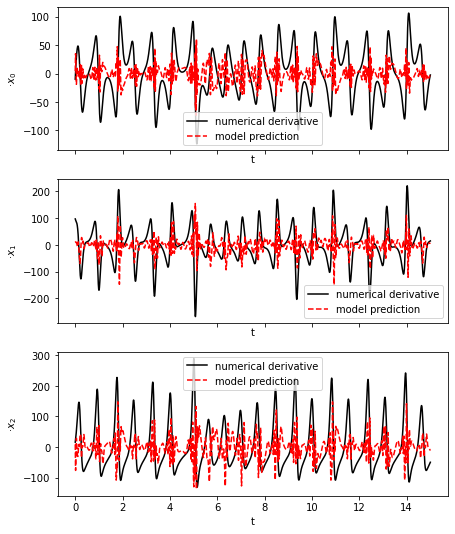

In [47]:
# the model prediction is quite bad of course 
# because the library has mostly useless terms
x_dot_test_predicted = model.predict(x_test)  

# Compute derivatives with a finite difference method, for comparison
x_dot_test_computed = model.differentiate(x_test, t=dt)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_dot_test_computed[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t_test, x_dot_test_predicted[:, i],
                'r--', label='model prediction')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
fig.show()

### Generalized library

Create the most general and flexible possible library by combining and tensoring as many libraries as you want, and you can even specify which input variables to use to generate each library! A much more advanced example is shown further below for PDEs.
One can specify:
<br>
1. N different libraries to add together
2. A list of inputs to use for each library. For two libraries with four inputs this would look like inputs_per_library = [[0, 1, 2, 3], [0, 1, 2, 3]] and to avoid using the first two input variables in the second library, you would change it to something like inputs_per_library = [[0, 1, 2, 3], [2, 2, 2, 3]], since duplicates are thrown out and [2, 2, 2, 3] will reduce to [2, 3]. 
        
3. A list of libraries to tensor together and add to the overall library. For four libraries, we could make three tensor libraries by using tensor_array = [[1, 0, 1, 1], [1, 1, 1, 1], [0, 0, 1, 1]]. The first sub-array takes the tensor product of libraries 0, 2, 3, the second takes the tensor product of all of them, and the last takes the tensor product of the libraries 2 and 3. This is a silly example since the [1, 1, 1, 1] tensor product already contains all the possible terms. <br>
<br>
Note that using this is a more advanced feature, but with the benefit that it allows any SINDy library you want. <br>

In [48]:
# Initialize two libraries
poly_library = ps.PolynomialLibrary(include_bias=False)
fourier_library = ps.FourierLibrary()

# Initialize the default inputs, i.e. each library
# uses all the input variables
inputs_temp = np.tile([0, 1, 2], 2)
inputs_per_library = np.reshape(inputs_temp, (2, 3))

# Don't use the x0 input for generating the Fourier library
inputs_per_library[1, 0] = 1

# Tensor all the polynomial and Fourier library terms together
tensor_array = [[1, 1]]

# Initialize this generalized library, all the work hidden from the user!
generalized_library = ps.GeneralizedLibrary([poly_library, fourier_library], 
                                            tensor_array=tensor_array,
                                            inputs_per_library=inputs_per_library)

# Fit the model and print the library feature names to check success
model = ps.SINDy(feature_library=generalized_library, 
                 feature_names=feature_names)
model.fit(x_train, t=dt)
model.print()
print("Feature names:\n", model.get_feature_names())

(x)' = -9.999 x + 9.999 y
(y)' = 27.992 x + -0.999 y + -1.000 x z
(z)' = -2.666 z + 1.000 x y
Feature names:
 ['x', 'y', 'z', 'x^2', 'x y', 'x z', 'y^2', 'y z', 'z^2', 'sin(1 y)', 'cos(1 y)', 'sin(1 z)', 'cos(1 z)', 'x sin(1 y)', 'x cos(1 y)', 'x sin(1 z)', 'x cos(1 z)', 'y sin(1 y)', 'y cos(1 y)', 'y sin(1 z)', 'y cos(1 z)', 'z sin(1 y)', 'z cos(1 y)', 'z sin(1 z)', 'z cos(1 z)', 'x^2 sin(1 y)', 'x^2 cos(1 y)', 'x^2 sin(1 z)', 'x^2 cos(1 z)', 'x y sin(1 y)', 'x y cos(1 y)', 'x y sin(1 z)', 'x y cos(1 z)', 'x z sin(1 y)', 'x z cos(1 y)', 'x z sin(1 z)', 'x z cos(1 z)', 'y^2 sin(1 y)', 'y^2 cos(1 y)', 'y^2 sin(1 z)', 'y^2 cos(1 z)', 'y z sin(1 y)', 'y z cos(1 y)', 'y z sin(1 z)', 'y z cos(1 z)', 'z^2 sin(1 y)', 'z^2 cos(1 y)', 'z^2 sin(1 z)', 'z^2 cos(1 z)']


## SINDy with control (SINDYc)
SINDy models with control inputs can also be learned. Here we learn a Lorenz control model:
$$ \dot{x} = \sigma (y - x) + u_0$$
$$ \dot{y} = x(\rho - z) - y $$
$$ \dot{z} = x y - \beta z - u_1$$

### Train the model

In [49]:
# Control input
def u_fun(t):
    return np.column_stack([np.sin(2 * t), t ** 2])

# Generate measurement data
dt = .002

t_train = np.arange(0, 10, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [-8, 8, 27]
x_train = solve_ivp(lorenz_control, t_train_span, x0_train, 
                    t_eval=t_train, args=(u_fun,), **integrator_keywords).y.T
u_train = u_fun(t_train)

In [50]:
# Instantiate and fit the SINDYc model
model = ps.SINDy()
model.fit(x_train, u=u_train, t=dt)
model.print()

(x0)' = -9.999 x0 + 9.999 x1 + 0.999 u0
(x1)' = 27.988 x0 + -0.998 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + -1.000 u1 + 1.000 x0 x1


### Assess results on a test trajectory

In [51]:
# Evolve the Lorenz equations in time using a different initial condition
t_test = np.arange(0, 15, dt)
t_test_span = (t_test[0], t_test[-1])
u_test = u_fun(t_test)
x0_test = np.array([8, 7, 15])
x_test = solve_ivp(lorenz_control, t_test_span, x0_test, 
                   t_eval=t_test, args=(u_fun,), **integrator_keywords).y.T
u_test = u_fun(t_test)

# Compare SINDy-predicted derivatives with finite difference derivatives
print('Model score: %f' % model.score(x_test, u=u_test, t=dt))

Model score: 1.000000


### Predict derivatives with learned model

/tmp/ipykernel_23392/3614315286.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


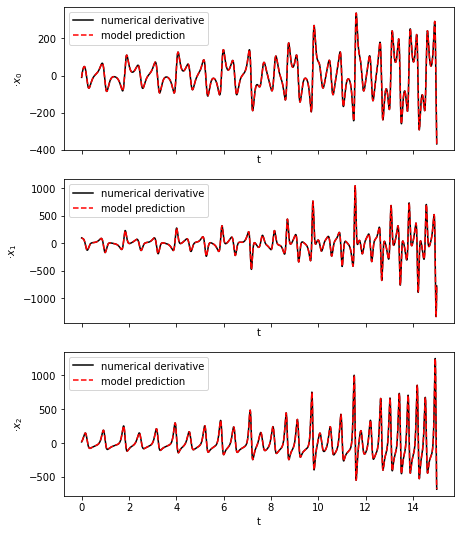

In [52]:
# Predict derivatives using the learned model
x_dot_test_predicted = model.predict(x_test, u=u_test)  

# Compute derivatives with a finite difference method, for comparison
x_dot_test_computed = model.differentiate(x_test, t=dt)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_dot_test_computed[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t_test, x_dot_test_predicted[:, i],
                'r--', label='model prediction')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
fig.show()

### Simulate forward in time (control input function known)
When working with control inputs `SINDy.simulate` requires a *function* to be passed in for the control inputs, `u`, because the default integrator used in `SINDy.simulate` uses adaptive time-stepping. We show what to do in the case when you do not know the functional form for the control inputs in the example following this one.

/tmp/ipykernel_23392/1951156729.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


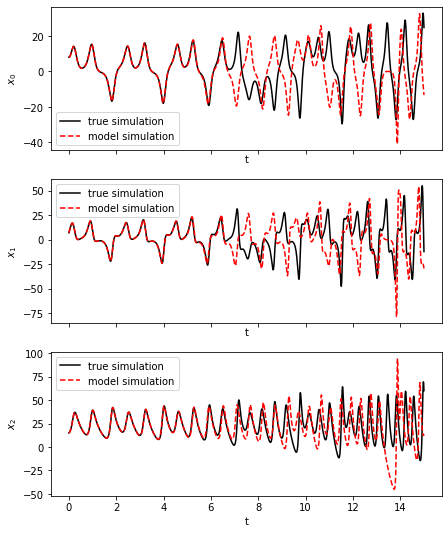

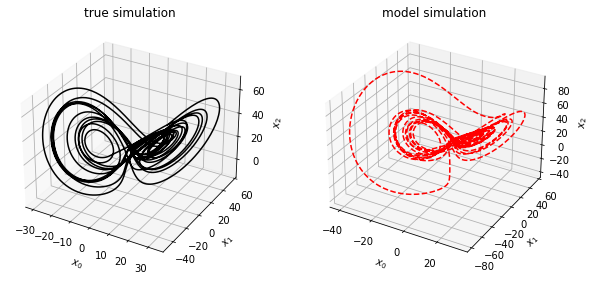

In [53]:
# Evolve the new initial condition in time with the SINDy model
x_test_sim = model.simulate(x0_test, t_test, u=u_fun)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_test[:, i], 'k', label='true simulation')
    axs[i].plot(t_test, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))

fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], 'k')
ax1.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='true simulation')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_test_sim[:, 0], x_test_sim[:, 1], x_test_sim[:, 2], 'r--')
ax2.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='model simulation')

fig.show()

### Simulate forward in time (unknown control input function)
If you only have a vector of control input values at the times in `t_test` and do not know the functional form for `u`, the `simulate` function will internally form an interpolating function based on the vector of control inputs. As a consequence of this interpolation procedure, `simulate` will not give a state estimate for the last time point in `t_test`. This is because the default integrator, `scipy.integrate.solve_ivp` (with LSODA as the default solver), is adaptive and sometimes attempts to evaluate the interpolant outside the domain of interpolation, causing an error.

In [54]:
u_test = u_fun(t_test)

/home/zack/pysindy/pysindy/pysindy.py:932: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.
  warnings.warn(


Length of t_test: 7500
Length of simulation: 7499


/tmp/ipykernel_23392/2107717416.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


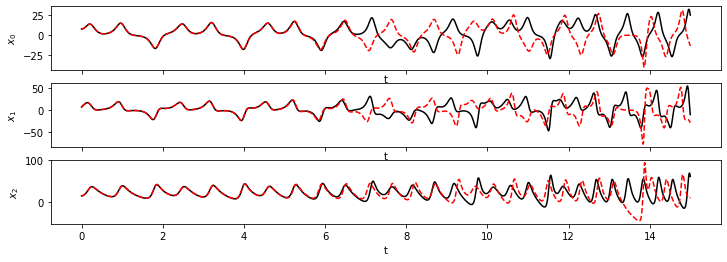

In [55]:
x_test_sim = model.simulate(x0_test, t_test, u=u_test)

# Note that the output is one example short of the length of t_test
print('Length of t_test:', len(t_test))
print('Length of simulation:', len(x_test_sim))

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(12, 4))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test[:-1], x_test[:-1, i], 'k', label='true simulation')
    axs[i].plot(t_test[:-1], x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))

fig.show()

## Implicit ODEs 
How would we use SINDy to solve an implicit ODE? In other words, now the LHS can depend on x and x_dot, 
$$\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x}, \dot{\mathbf{x}})$$


In order to deal with this, we need a library $\Theta(\mathbf{x}, \dot{\mathbf{x}})$. SINDy parallel implicit (SINDy-PI) is geared to solve these problems. It solves the optimization problem,
$$argmin_\mathbf{\Xi} (\|\Theta(\mathbf{X}, \dot{\mathbf{X}}) - \Theta(\mathbf{X}, \dot{\mathbf{X}})\mathbf{\Xi}\| + \lambda \|\mathbf{\Xi}\|_1)$$
such that diag$(\mathbf{\Xi}) = 0$. So for every candidate library term it generates a different model. With N state variables, we need to choose N of the equations to solve for the system evolution. See the [SINDy-PI notebook](https://github.com/dynamicslab/pysindy/blob/master/examples/9_sindypi_with_sympy.ipynb) for more details. 

Here we illustrate successful identification of the 1D Michelson-Menten enzyme model
$$\dot{x} = 0.6 - \frac{1.5 x}{0.3 + x}.$$
Or, equivalently
$$\dot{x} = 0.6 - 3 x - \frac{10}{3} x\dot{x}.$$

Note that some of the model fits fail. This is usually because the LHS term being fitted is a poor match to the data, but this error can also be caused by CVXPY not liking the parameters passed to the solver.


In [56]:
# define parameters
r = 1
dt = 0.001
T = 4
t = np.arange(0, T + dt, dt)
t_span = (t[0], t[-1])
x0_train = [0.55]
x_train = solve_ivp(enzyme, t_span, x0_train, 
                    t_eval=t, **integrator_keywords).y.T

# Initialize custom SINDy library so that we can have 
# x_dot inside it. 
x_library_functions = [
    lambda x: x,
    lambda x, y: x * y,
    lambda x: x ** 2,
    lambda x, y, z: x * y * z,
    lambda x, y: x * y ** 2,
    lambda x: x ** 3,
    lambda x, y, z, w: x * y * z * w,
    lambda x, y, z: x * y * z ** 2,
    lambda x, y: x * y ** 3,
    lambda x: x ** 4,
]
x_dot_library_functions = [lambda x: x]

# library function names includes both the x_library_functions 
# and x_dot_library_functions names
library_function_names = [
    lambda x: x,
    lambda x, y: x + y,
    lambda x: x + x,
    lambda x, y, z: x + y + z,
    lambda x, y: x + y + y,
    lambda x: x + x + x,
    lambda x, y, z, w: x + y + z + w,
    lambda x, y, z: x + y + z + z,
    lambda x, y: x + y + y + y,
    lambda x: x + x + x + x,
    lambda x: x,
]

# Need to pass time base to the library so can build the x_dot library from x
sindy_library = ps.SINDyPILibrary(
    library_functions=x_library_functions,
    x_dot_library_functions=x_dot_library_functions,
    t=t,
    function_names=library_function_names,
    include_bias=True,
)

# Use the SINDy-PI optimizer, which relies on CVXPY.
# Note that if LHS of the equation fits the data poorly,
# CVXPY often returns failure.
sindy_opt = ps.SINDyPI(
    threshold=1e-6,
    tol=1e-8,
    thresholder="l1",
    max_iter=20000,
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)
model.print()

/home/zack/pysindy/pysindy/feature_library/sindy_pi_library.py:161: UserWarning: This library is deprecated in PySINDy versions > 1.7. Please use the PDE or WeakPDE libraries instead. 
  warnings.warn(


Model  0
Model  1
Model  2
Model  3
Solver failed on model  3 , setting coefs to zeros
Model  4
Model  5
Model  6
Model  7
Model  8
Model  9
1 = 5.000 x0 + 1.667 x0_dot + 5.556 x0x0_dot
x0 = 0.200 1 + -0.333 x0_dot + -1.111 x0x0_dot
x0x0 = 0.198 x0 + 0.007 x0x0x0 + -0.338 x0x0_dot + -1.099 x0x0x0_dot
x0x0x0 = 0.000
x0x0x0x0 = -0.001 1 + 0.363 x0x0x0 + 0.041 x0x0_dot + -1.205 x0x0x0x0x0_dot
x0_dot = 0.600 1 + -3.000 x0 + -3.333 x0x0_dot
x0x0_dot = 0.180 1 + -0.900 x0 + -0.300 x0_dot
x0x0x0_dot = -0.004 1 + 0.136 x0 + -0.508 x0x0 + -0.344 x0x0x0 + -0.102 x0x0_dot + -0.219 x0x0x0x0x0_dot
x0x0x0x0_dot = 0.003 1 + 0.001 x0 + -0.391 x0x0x0 + -0.247 x0x0x0x0 + -0.108 x0x0_dot
x0x0x0x0x0_dot = 0.001 1 + -0.670 x0x0x0x0 + -0.005 x0_dot + 0.029 x0x0_dot + -0.271 x0x0x0_dot


# PDEFIND Feature Overview
PySINDy now supports SINDy for PDE identification (PDE-FIND) (Rudy, Samuel H., Steven L. Brunton, Joshua L. Proctor, and J. Nathan Kutz. "Data-driven discovery of partial differential equations." Science Advances 3, no. 4 (2017): e1602614.). We illustrate a basic example on Burgers' equation:
$$u_t = -uu_x + 0.1u_{xx}$$

Note that for noisy PDE data, the most robust method is to use the weak form of PDEFIND (see below)!

In [57]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso

from pysindy.utils import enzyme
from pysindy.utils import lorenz
from pysindy.utils import lorenz_control
import pysindy as ps

# bad code but allows us to ignore warnings
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)

(x0)' = 0.100 x0_11 + -1.001 x0x0_1


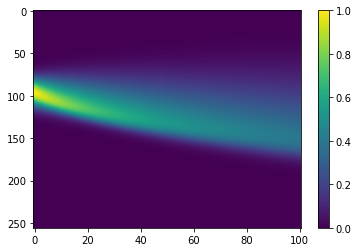

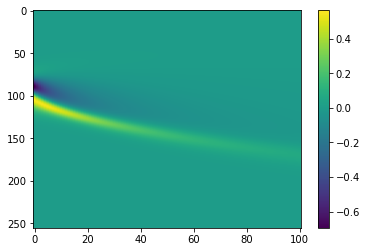

In [58]:
from scipy.io import loadmat

# Load data
data = loadmat("data/burgers.mat")
t = np.ravel(data["t"])
x = np.ravel(data["x"])
u = np.real(data["usol"])
dt = t[1] - t[0]
dx = x[1] - x[0]
u_dot = ps.FiniteDifference(axis=-1)._differentiate(u, t=dt)

# Plot the spatiotemporal data
plt.figure()
plt.imshow(u, aspect="auto")
plt.colorbar()
plt.figure()
plt.imshow(u_dot, aspect="auto")
plt.colorbar()
u = np.reshape(u, (len(x), len(t), 1))

# Define quadratic library with up to third order derivatives 
# on a uniform spatial grid
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=3,
    spatial_grid=x,
    is_uniform=True,
)

optimizer = ps.STLSQ(threshold=0.1, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# Note that the dimensions of u are reshaped internally,
# according to the dimensions in spatial_grid
model.fit(u, t=dt)
model.print()

### Weak formulation system identification improves robustness to noise.
PySINDy also supports weak form PDE identification following Reinbold et al. (2019).

In [59]:
# Same library but using the weak formulation
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
X, T = np.meshgrid(x, t)
XT = np.array([X, T]).T
pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=3,
    spatiotemporal_grid=XT,
    is_uniform=True,
)

In [60]:
optimizer = ps.STLSQ(threshold=0.01, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)

# Note that reshaping u is done internally
model.fit(u, t=dt)
model.print()

(x0)' = 0.101 x0_11 + -1.003 x0x0_1


### GeneralizedLibrary
The `GeneralizedLibrary` is meant for identifying ODEs/PDEs the depend on the spatial and/or temporal coordinates and/or nonlinear functions of derivative terms.

Often, especially for PDEs, there is some explicit spatiotemporal dependence such as through an external potential. For instance, a well known PDE is the Poisson equation for the electric potential in 2D:
$$ (\partial_{xx} + \partial_{yy})\phi(x, y) = \rho(x,y).$$


**Note that all other SINDy libraries implemented in PySINDy only allow for functions of $\phi(x, y)$ on the RHS of the SINDy equation.** This method allows for functions of the spatial and temporal coordinates like $\rho(x, y)$, as well as anything else you can imagine.

Let's suppose we have a distribution like the following
$$ \rho(x, y) = x^2 + y^2$$
We can actually directly input $(\partial_{xx} + \partial_{yy})\phi(x, y)$ as "x_dot" in the SINDy fit, functionally replacing the normal left-hand-side (LHS) of the SINDy equation. Then we can build a candidate library of terms to discover the correct charge density matching this data.

In the following, we will build three different libraries, each using their own subset of inputs, tensor a subset of them together, and fit a model. This is total overkill for this problem but hopefully is illustrative.

In [61]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso

from pysindy.utils import enzyme
from pysindy.utils import lorenz
from pysindy.utils import lorenz_control
import pysindy as ps

# bad code but allows us to ignore warnings
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)

(x0)' = 1.045 x1^2 + 1.061 x2^2
(x1)' = 1.000 x1
(x2)' = 1.000 x2


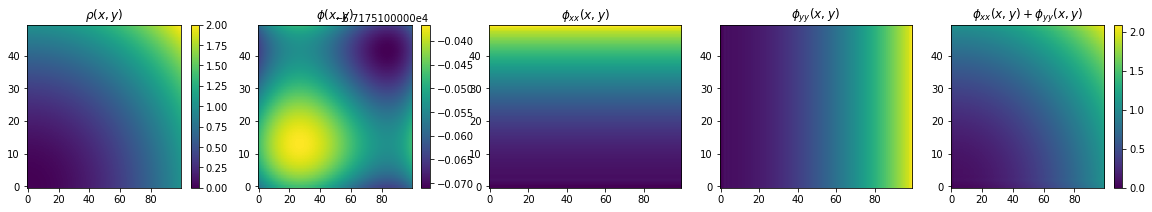

In [62]:
# Define the spatial grid
nx = 50
Lx = 1
ny = 100
Ly = 1
x = np.linspace(0, Lx, nx)
dx = x[1] - x[0]
y = np.linspace(0, Ly, ny)
dy = y[1] - y[0]
X, Y = np.meshgrid(x, y, indexing="ij")

# Define rho
rho = X ** 2 + Y ** 2
plt.figure(figsize=(20, 3))
plt.subplot(1, 5, 1)
plt.imshow(rho, aspect="auto", origin="lower")
plt.title(r"$\rho(x, y)$")
plt.colorbar()

# Generate the PDE data for phi by fourier transforms 
# since this is homogenous PDE
# and we assume periodic boundary conditions
nx2 = int(nx / 2)
ny2 = int(ny / 2)
# Define Fourier wavevectors (kx, ky)
kx = (2 * np.pi / Lx) * np.hstack(
    (np.linspace(0, nx2 - 1, nx2), np.linspace(-nx2, -1, nx2))
)
ky = (2 * np.pi / Ly) * np.hstack(
    (np.linspace(0, ny2 - 1, ny2), np.linspace(-ny2, -1, ny2))
)

# Get 2D mesh in (kx, ky)
KX, KY = np.meshgrid(kx, ky, indexing="ij")
K2 = KX ** 2 + KY ** 2
K2[0, 0] = 1e-5

# Generate phi data by solving the PDE and plot results
phi = np.real(np.fft.ifft2(-np.fft.fft2(rho) / K2))
plt.subplot(1, 5, 2)
plt.imshow(phi, aspect="auto", origin="lower")
plt.title(r"$\phi(x, y)$")
plt.colorbar()

# Make del^2 phi and plot various quantities
phi_xx = ps.FiniteDifference(d=2, axis=0)._differentiate(phi, dx)
phi_yy = ps.FiniteDifference(d=2, axis=1)._differentiate(phi, dy)
plt.subplot(1, 5, 3)
plt.imshow(phi_xx, aspect="auto", origin="lower")
plt.title(r"$\phi_{xx}(x, y)$")
plt.subplot(1, 5, 4)
plt.imshow(phi_yy, aspect="auto", origin="lower")
plt.title(r"$\phi_{yy}(x, y)$")
plt.subplot(1, 5, 5)
plt.imshow(
    phi_xx + phi_yy + abs(np.min(phi_xx + phi_yy)),
    aspect="auto",
    origin="lower",
)
plt.title(r"$\phi_{xx}(x, y) + \phi_{yy}(x, y)$")
plt.colorbar()

# Define a PolynomialLibrary, FourierLibrary, and PDELibrary
poly_library = ps.PolynomialLibrary(include_bias=False)
fourier_library = ps.FourierLibrary()
X_mesh, Y_mesh = np.meshgrid(x, y)
pde_library = ps.PDELibrary(
    derivative_order=1, 
    spatial_grid=np.asarray([X_mesh, Y_mesh]).T
)

# Inputs are going to be all the variables [phi, X, Y].
# Remember we can use a subset of these input variables to generate each library
data = np.transpose(np.asarray([phi, X, Y]), [1, 2, 0])

# The 'x_dot' terms will be [phi_xx, X, Y]
# Remember these are the things that are being fit in the SINDy regression
Laplacian_phi = phi_xx + phi_yy + abs(np.min(phi_xx + phi_yy))
data_dot = np.transpose(np.asarray([Laplacian_phi, X, Y]), [1, 2, 0])

# Tensor polynomial library with the PDE library
tensor_array = [[1, 0, 1]]

# Remove X and Y from PDE library terms because why would we take these derivatives
inputs_temp = np.tile([0, 1, 2], 3)
inputs_per_library = np.reshape(inputs_temp, (3, 3))
inputs_per_library[2, 1] = 0
inputs_per_library[2, 2] = 0

# Fit a generalized library of 3 feature libraries + 1 internally 
# generated tensored library and only use the input variable phi 
# for the PDELibrary. Note that this holds true both for the 
# individual PDELibrary and any tensored libraries constructed from it.
generalized_library = ps.GeneralizedLibrary(
    [poly_library, fourier_library, pde_library],
    tensor_array=tensor_array,
    inputs_per_library=inputs_per_library,
)
optimizer = ps.STLSQ(threshold=8,alpha=1e-3, normalize_columns=True)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer)
model.fit(data, x_dot=data_dot)

# Note scale of phi is large so some coefficients >> 1
# --> would want to rescale phi with eps_0 for a harder problem
model.print()

Feature names:
 ['x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2', 'sin(1 x0)', 'cos(1 x0)', 'sin(1 x1)', 'cos(1 x1)', 'sin(1 x2)', 'cos(1 x2)', 'x0_2', 'x0_1', 'x0 x0_2', 'x0 x0_1', 'x1 x0_2', 'x1 x0_1', 'x2 x0_2', 'x2 x0_1', 'x0^2 x0_2', 'x0^2 x0_1', 'x0 x1 x0_2', 'x0 x1 x0_1', 'x0 x2 x0_2', 'x0 x2 x0_1', 'x1^2 x0_2', 'x1^2 x0_1', 'x1 x2 x0_2', 'x1 x2 x0_1', 'x2^2 x0_2', 'x2^2 x0_1']


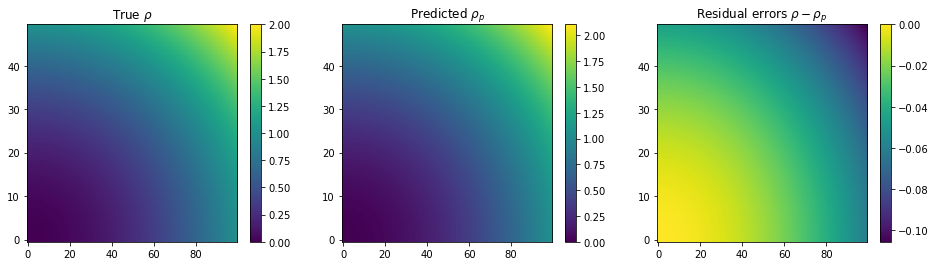

In [63]:
# Get prediction of rho and plot results
#predict expects a time axis...so add one and ignore it...
data_shaped=data.reshape((data.shape[0],data.shape[1],1,data.shape[2]))
rho_pred = model.predict(data_shaped)[:,:,0,:]
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.title(r'True $\rho$')
plt.imshow(rho, aspect='auto', origin='lower')
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title(r'Predicted $\rho_p$')
plt.imshow(rho_pred[:, :, 0], aspect='auto', origin='lower')
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title(r'Residual errors $\rho - \rho_p$')
plt.imshow(rho - rho_pred[:, :, 0], aspect='auto', origin='lower')
plt.colorbar()
print("Feature names:\n", model.get_feature_names())